# Problem 1 — Monotonicity Transformation

This notebook implements the monotonicity transformation described in the lab. It reads `Lena.png` (must be in the same directory), converts it to grayscale **without** using the built-in conversion function, applies the monotonicity transformation to map the image to the following output pixel ranges, and displays the results:

- {0,1,2,...,1023} (L' = 1024)
- {0,1,2,...,511}  (L' = 512)
- {0,1,2,...,255}  (L' = 256)
- {0,1,2,...,127}  (L' = 128)

The cell also prints the min/max value and dtype for each transformed image to confirm the ranges.

L'=1024: dtype=uint16, min=0, max=1023
L'=512: dtype=uint16, min=0, max=511
L'=256: dtype=uint8, min=0, max=255
L'=128: dtype=uint8, min=0, max=127
L'=1024: visual-scale MSE vs original = 143.7211
L'=512: visual-scale MSE vs original = 145.7642
L'=256: visual-scale MSE vs original = 143.3098
L'=128: visual-scale MSE vs original = 146.5363


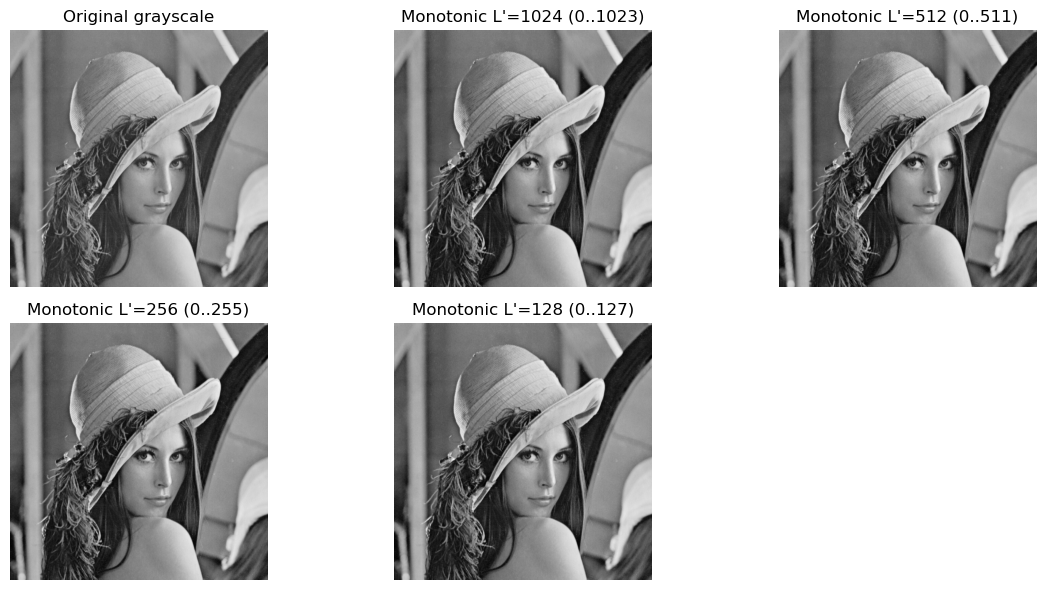

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read Lena.png
img = cv2.imread('Lena.png', cv2.IMREAD_COLOR)
if img is None:
    raise FileNotFoundError("Lena.png not found in the notebook working directory. Place Lena.png next to this notebook.")

# Convert to grayscale WITHOUT using built-in cv2.cvtColor
# Use standard luminance weights: Y = 0.299 R + 0.587 G + 0.114 B
b = img[:, :, 0].astype(np.float32)
g = img[:, :, 1].astype(np.float32)
r = img[:, :, 2].astype(np.float32)
gray = (0.299 * r + 0.587 * g + 0.114 * b)
gray = np.round(gray).astype(np.uint8)

# Monotonicity transform function
def monotonic_transform(f_gray, L_prime):
    f = f_gray.astype(np.float32)
    minv = f.min()
    h = f - minv
    maxv = h.max()
    if maxv == 0:
        hnorm = np.zeros_like(h)
    else:
        hnorm = h / maxv
    hscaled = hnorm * (L_prime - 1)
    # Choose an appropriate dtype to hold the range
    if L_prime <= 256:
        dtype = np.uint8
    elif L_prime <= 65536:
        dtype = np.uint16
    else:
        dtype = np.int32
    return np.round(hscaled).astype(dtype)

# Visualization helper: scale any image to 0..255 for display
def scale_to_uint8(img):
    f = img.astype(np.float32)
    mn = f.min()
    mx = f.max()
    if mx == mn:
        return np.zeros_like(f, dtype=np.uint8)
    disp = (f - mn) * (255.0 / (mx - mn))
    return np.round(disp).astype(np.uint8)

L_primes = [1024, 512, 256, 128]
transformed = [monotonic_transform(gray, L) for L in L_primes]

# Display original and transformed images
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.title('Original grayscale')
plt.axis('off')

for i, (L, img_t) in enumerate(zip(L_primes, transformed), start=2):
    plt.subplot(2, 3, i)
    plt.imshow(scale_to_uint8(img_t), cmap='gray', vmin=0, vmax=255)
    plt.title(f"Monotonic L'={L} (0..{L-1})")
    plt.axis('off')

plt.tight_layout()

# Print ranges & types to confirm
for L, img_t in zip(L_primes, transformed):
    print(f"L'={L}: dtype={img_t.dtype}, min={int(img_t.min())}, max={int(img_t.max())}")

# Optional: compute simple differences and MSE between original grayscale and the scaled-back transformed images
for L, img_t in zip(L_primes, transformed):
    recon = scale_to_uint8(img_t)
    mse = np.mean((gray.astype(np.float32) - recon.astype(np.float32))**2)
    print(f"L'={L}: visual-scale MSE vs original = {mse:.4f}")
